# 淘宝用户行为分析案例

## 一、数据背景

数据来源自阿里云天池的阿里移动推荐算法竞赛，以淘宝app平台在2014年11月18日-12月18日的数据为数据集。值得注意的是，“双十二”大型促销活动的数据也会大量包含在数据集中，初步推断“双十二”当天的数据应该会出现井喷现象。

相关链接：https://tianchi.aliyun.com/dataset/dataDetail?dataId=46&userId=1

在这里通过行业的指标对淘宝用户行为进行分析。结合常见的电商数据分析模型与python数据分析及可视化，可以进行分析任务：1、每日pv统计、每日uv统计；2、每日用户行为趋势；3、漏斗模型：用户行为转化分析；4、周期内用户行为频率。

## 二、数据读取

从数据集读取数据后初步检查数据的字段信息、缺失情况。

user数据集包含6个字段，描述的是淘宝用户对商品进行操作行为，字段有user_id(用户名ID)、item_id(商品ID)、behavior_type(用户行为1-4)、user_geohash(用户地理位置)、item_category(商品类别)、time(行为时间)，而只有user_geohash存在缺失值，缺失条目总计8334824，缺失率达到68%。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
user = pd.read_csv('D:/datasets/taobao_user_behaviour/tianchi_mobile_recommend_train_user.csv')

In [3]:
user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


In [4]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256906 entries, 0 to 12256905
Data columns (total 6 columns):
user_id          int64
item_id          int64
behavior_type    int64
user_geohash     object
item_category    int64
time             object
dtypes: int64(4), object(2)
memory usage: 561.1+ MB


In [5]:
user.isnull().sum()

user_id                0
item_id                0
behavior_type          0
user_geohash     8334824
item_category          0
time                   0
dtype: int64

In [6]:
user.isnull().mean()

user_id          0.00000
item_id          0.00000
behavior_type    0.00000
user_geohash     0.68001
item_category    0.00000
time             0.00000
dtype: float64

以下进行数据清洗，步骤：1、对于geohash的处理，不能删除缺失值，因为地理信息在数据集收集过程中做过加密转换，因此对数据集不做处理；2、规范user数据集的time字段格式；3、利用time作为user数据集的索引并按时序排列；4、把behavior_type进行离散化处理。

In [7]:
user['time'] = pd.to_datetime(user['time'], format='%Y-%m-%d %H')

In [8]:
user['time']

0          2014-12-06 02:00:00
1          2014-12-09 20:00:00
2          2014-12-18 11:00:00
3          2014-12-06 10:00:00
4          2014-12-16 21:00:00
5          2014-12-03 20:00:00
6          2014-12-13 20:00:00
7          2014-11-27 16:00:00
8          2014-12-11 23:00:00
9          2014-12-05 23:00:00
10         2014-12-08 17:00:00
11         2014-12-13 21:00:00
12         2014-12-01 13:00:00
13         2014-12-12 11:00:00
14         2014-12-11 19:00:00
15         2014-11-20 23:00:00
16         2014-12-14 12:00:00
17         2014-12-09 16:00:00
18         2014-11-26 11:00:00
19         2014-11-21 12:00:00
20         2014-12-12 12:00:00
21         2014-12-08 21:00:00
22         2014-11-28 09:00:00
23         2014-12-05 11:00:00
24         2014-11-23 21:00:00
25         2014-11-29 09:00:00
26         2014-11-25 19:00:00
27         2014-12-05 23:00:00
28         2014-12-15 14:00:00
29         2014-12-16 21:00:00
                   ...        
12256876   2014-12-16 22:00:00
12256877

In [9]:
user = user.set_index('time')

In [10]:
user = user.sort_index()

In [11]:
user = pd.get_dummies(user, prefix='type', columns=['behavior_type'])

In [12]:
user = user.rename(columns={'type_1': 'click', 'type_2': 'collect', 'type_3': 'add-to-cart', 'type_4': 'payment'})

In [13]:
user.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12256906 entries, 2014-11-18 00:00:00 to 2014-12-18 23:00:00
Data columns (total 8 columns):
user_id          int64
item_id          int64
user_geohash     object
item_category    int64
click            uint8
collect          uint8
add-to-cart      uint8
payment          uint8
dtypes: int64(3), object(1), uint8(4)
memory usage: 514.3+ MB


In [14]:
user.index.rename('datetime', inplace=True)

In [15]:
user['date'] = pd.to_datetime(user.index.date)

In [16]:
user['hour'] = user.index.hour

In [17]:
user.sample(10)

,user_id,item_id,user_geohash,item_category,click,collect,add-to-cart,payment,date,hour
datetime,,,,,,,,,,
2014-11-26 18:00:00,14355777,365413361,NaN,11406,1,0,0,0,2014-11-26,18
2014-11-23 08:00:00,113552018,87503674,NaN,3431,1,0,0,0,2014-11-23,8
2014-12-05 20:00:00,120839939,372399781,9r63ol4,3783,1,0,0,0,2014-12-05,20
2014-11-19 14:00:00,67893893,180689610,NaN,4370,0,0,1,0,2014-11-19,14
2014-12-06 00:00:00,25265512,295779947,NaN,7344,0,1,0,0,2014-12-06,0
2014-11-29 23:00:00,71208218,288047660,NaN,5027,1,0,0,0,2014-11-29,23
2014-12-03 00:00:00,103134579,334141176,NaN,10894,1,0,0,0,2014-12-03,0
2014-11-23 19:00:00,126046148,153366609,NaN,3070,1,0,0,0,2014-11-23,19
2014-11-29 22:00:00,28930771,381658145,NaN,3378,1,0,0,0,2014-11-29,22


## 三、分析数据

1、每日pv统计、每日uv统计

In [18]:
pv_daily = user[user['click'] == 1].groupby('date')['user_id'].count()

In [19]:
pv_daily

date
2014-11-18    345855
2014-11-19    337870
2014-11-20    332792
2014-11-21    314572
2014-11-22    340563
2014-11-23    361221
2014-11-24    357192
2014-11-25    349392
2014-11-26    340621
2014-11-27    350040
2014-11-28    321813
2014-11-29    344127
2014-11-30    379439
2014-12-01    372095
2014-12-02    382052
2014-12-03    387497
2014-12-04    376307
2014-12-05    340976
2014-12-06    367126
2014-12-07    376596
2014-12-08    364097
2014-12-09    374261
2014-12-10    397661
2014-12-11    460329
2014-12-12    641507
2014-12-13    385337
2014-12-14    380717
2014-12-15    376624
2014-12-16    373399
2014-12-17    363757
2014-12-18    354746
Name: user_id, dtype: int64

In [20]:
pv_daily.sum()

11550581

In [21]:
uv_daily = user[user['click'] == 1].groupby('date')['user_id'].nunique()

In [22]:
uv_daily

date
2014-11-18    6340
2014-11-19    6418
2014-11-20    6332
2014-11-21    6275
2014-11-22    6184
2014-11-23    6371
2014-11-24    6511
2014-11-25    6346
2014-11-26    6353
2014-11-27    6357
2014-11-28    6185
2014-11-29    6220
2014-11-30    6378
2014-12-01    6543
2014-12-02    6547
2014-12-03    6581
2014-12-04    6528
2014-12-05    6364
2014-12-06    6438
2014-12-07    6420
2014-12-08    6560
2014-12-09    6563
2014-12-10    6649
2014-12-11    6892
2014-12-12    7718
2014-12-13    6774
2014-12-14    6668
2014-12-15    6784
2014-12-16    6726
2014-12-17    6636
2014-12-18    6576
Name: user_id, dtype: int64

In [23]:
uv_daily.sum()

202237

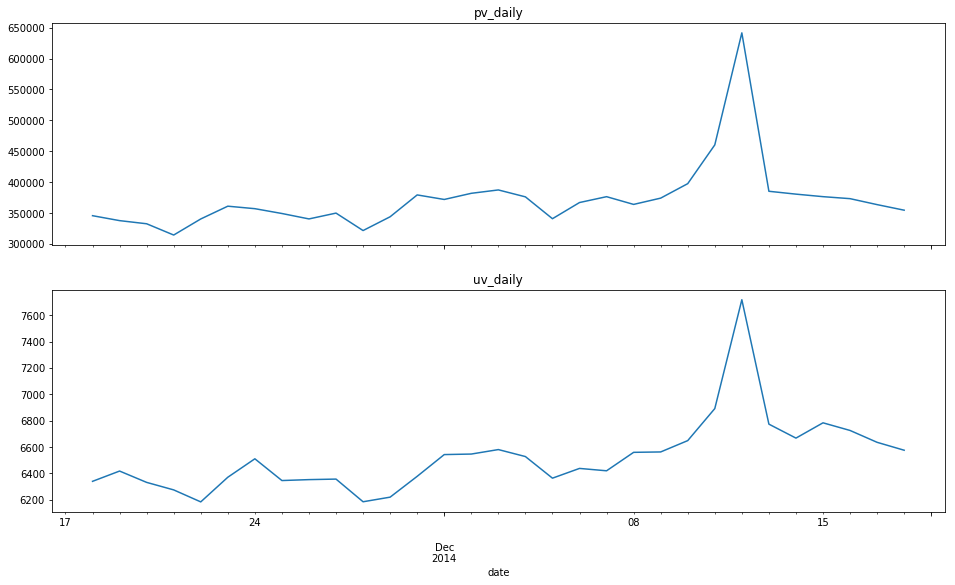

In [24]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(16, 9))
pv_daily.plot(ax=axes[0], title='pv_daily')
uv_daily.plot(ax=axes[1], title='uv_daily')

2、每日用户行为趋势

In [25]:
behaviors_detail = user.groupby('date')[['click', 'collect', 'add-to-cart', 'payment']].sum().astype(int)

In [26]:
behaviors_detail

,click,collect,add-to-cart,payment
date,,,,
2014-11-18,345855,6904,10212,3730
2014-11-19,337870,7152,10115,3686
2014-11-20,332792,7167,10008,3462
2014-11-21,314572,6832,8679,3021
2014-11-22,340563,7252,9970,3570
2014-11-23,361221,7702,10432,3347
2014-11-24,357192,7333,10391,3426
2014-11-25,349392,7492,9891,3464
2014-11-26,340621,7324,9378,3573


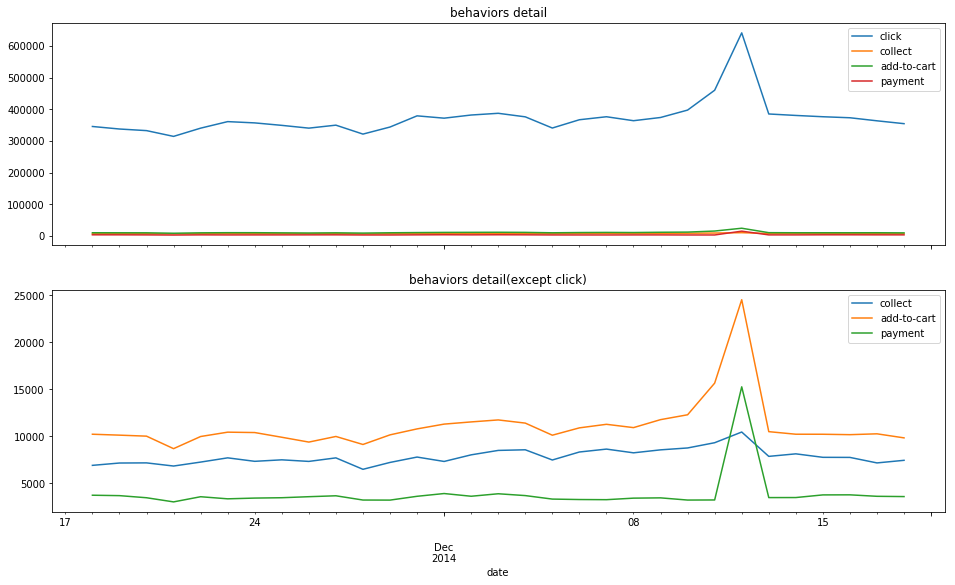

In [27]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 9), sharex=True)
behaviors_detail.plot(ax=axes[0], title='behaviors detail')
behaviors_detail[['collect', 'add-to-cart', 'payment']].plot(ax=axes[1], title='behaviors detail(except click)')

从上折线图中不难发现，除“双十二”当日外，每日pv量大概在30万-40万次之间。而“双十二”当日活动则为淘宝平台点击量、收藏量、加入购物车次数以及商品支付次数带来明显增长，尤其是点击量的增长量可以说是其他行为望尘莫及的，而商品支付次数则明显增长若干倍。

3、漏斗模型：用户行为转化分析

In [28]:
user_item = user.groupby(['user_id', 'item_id'])[['click', 'add-to-cart', 'payment']].max()

In [29]:
user_item.sum()

click          4677501
add-to-cart     282429
payment         102996
dtype: int64

In [30]:
user_item.mean().apply(lambda x:format(x, '.2%'))

click          99.80%
add-to-cart     6.03%
payment         2.20%
dtype: object

以上统计转化流程的数据，忽略每名用户的行为频率，即只要出现过点击、加入购物车、支付的行为，相应值则为1；没有出现过相应用户行为的话，值则为0。

In [31]:
user_item_total = user.groupby(['user_id', 'item_id'])[['click', 'add-to-cart', 'payment']].sum()

In [32]:
user_item_total.sum()

click          11550581
add-to-cart      343564
payment          120205
dtype: int64

In [33]:
(user_item_total.sum() / pv_daily.sum()).apply(lambda x:format(x, '.2%'))

click          100.00%
add-to-cart      2.97%
payment          1.04%
dtype: object

Text(0.5,1,'include behavior frequency')

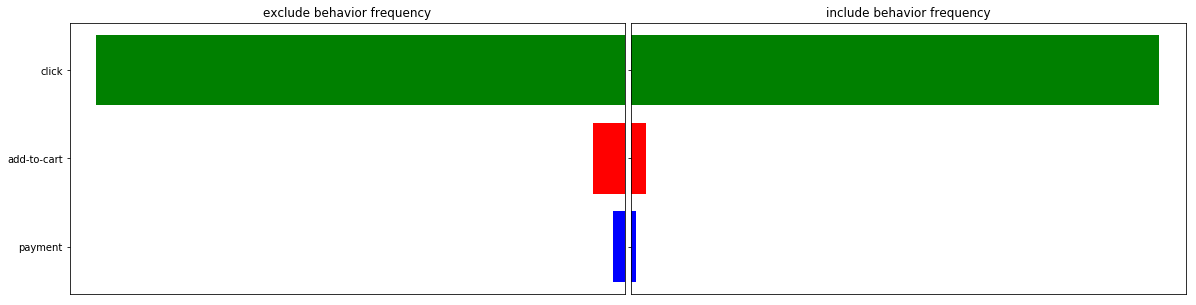

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0.01)
axes[0].set_xticks([])
axes[0].barh(user_item.mean().sort_values().index, user_item.mean().sort_values().values*-1, color=['b', 'r', 'g'])
axes[0].set_title('exclude behavior frequency')
axes[1].set_xticks([])
axes[1].barh((user_item_total.sum() / pv_daily.sum()).sort_values().index, (user_item_total.sum() / pv_daily.sum()).sort_values().values, color=['b', 'r', 'g'])
axes[1].set_title('include behavior frequency')

(这很漏斗)

再针对用户的行为频率来统计转化流程，把用户的行为频率进行相应累加。计算出点击量共11550581次，支付次数共120205次。

可以看出，在这30天内，点击量非常庞大，但通过无论点击转化为加入购物车还是最终支付，转化率都极低。

4、周期内用户行为频率

In [35]:
behavior_freq = user.groupby('user_id')[['click', 'collect', 'add-to-cart', 'payment']].sum().astype(int)

In [36]:
behavior_freq

,click,collect,add-to-cart,payment
user_id,,,,
4913,1658,49,29,6
6118,112,4,0,1
7528,183,1,24,6
7591,824,0,14,21
12645,248,2,10,8
45368,36,0,0,0
54056,34,2,0,2
63348,223,14,13,1
79824,650,0,0,13


In [37]:
behavior_freq.describe()

,click,collect,add-to-cart,payment
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1155.058100,24.255600,34.356400,12.020500
std,1430.052774,73.900635,63.889429,19.050621
min,1.000000,0.000000,0.000000,0.000000
25%,297.000000,0.000000,2.000000,2.000000
50%,703.000000,2.000000,12.000000,7.000000
75%,1461.000000,18.000000,39.000000,15.000000
max,27720.000000,2935.000000,1810.000000,809.000000


In [38]:
shuangshier_behavior_freq = user.loc['2014-12-12'].groupby('user_id')[['click', 'collect', 'add-to-cart', 'payment']].sum().astype(int)

In [39]:
shuangshier_behavior_freq

,click,collect,add-to-cart,payment
user_id,,,,
4913,17,0,0,0
6118,2,0,0,0
7591,67,0,0,4
63348,4,0,0,0
79824,41,0,0,3
88930,21,1,1,4
90472,17,1,0,0
100539,83,0,4,0
104155,2,0,0,0


In [40]:
shuangshier_behavior_freq.describe()

,click,collect,add-to-cart,payment
count,7720.000000,7720.000000,7720.000000,7720.000000
mean,83.096762,1.353109,3.174611,1.975518
std,112.196364,4.888727,7.062714,4.393732
min,0.000000,0.000000,0.000000,0.000000
25%,15.750000,0.000000,0.000000,0.000000
50%,45.000000,0.000000,1.000000,1.000000
75%,106.000000,1.000000,3.000000,2.000000
max,1743.000000,165.000000,160.000000,185.000000


C:\Users\jason\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


30日内大多数用户支付次数：0次


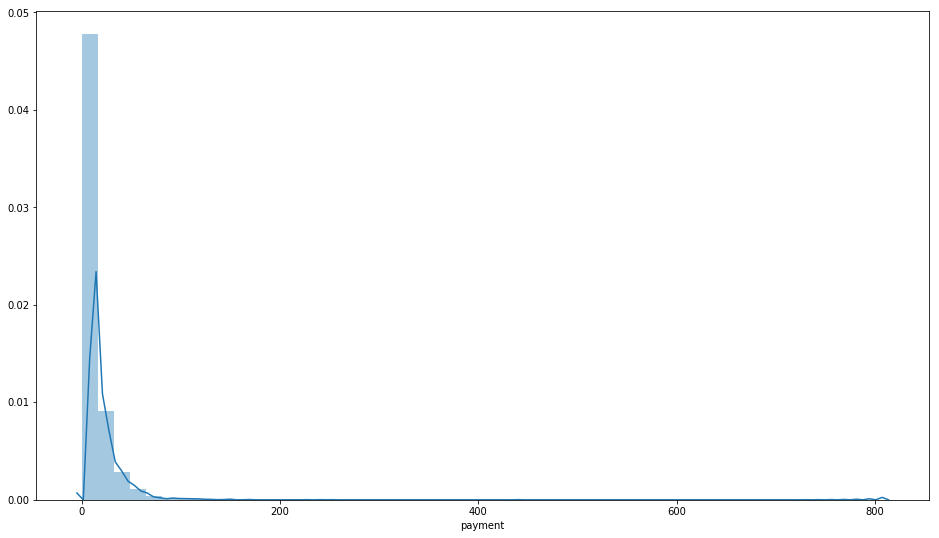

In [41]:
fig = plt.figure(figsize=(16, 9))
sns.distplot(behavior_freq['payment'])
print('30日内大多数用户支付次数：{}次'.format(behavior_freq['payment'].mode()[0]))

C:\Users\jason\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


“双十二”当日大多数用户支付次数：0次


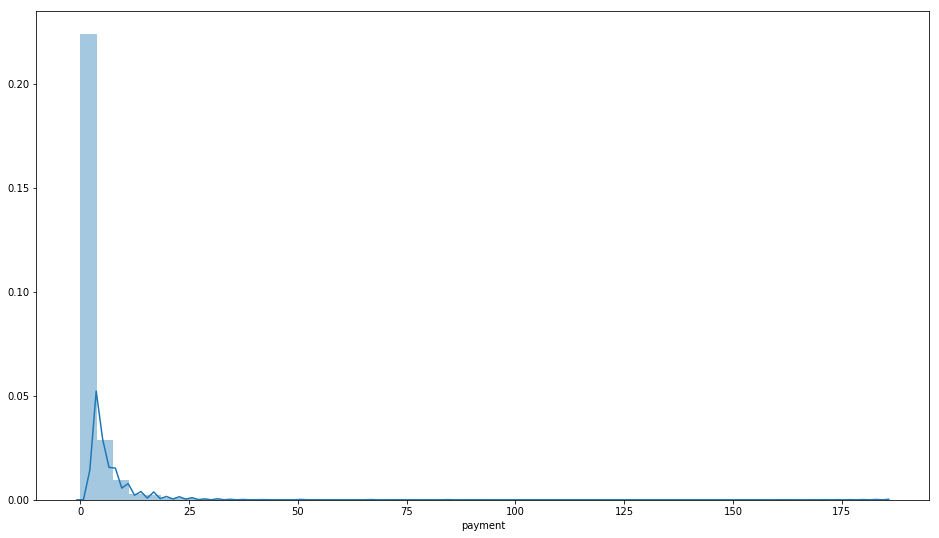

In [42]:
fig = plt.figure(4, figsize=(16, 9))
sns.distplot(shuangshier_behavior_freq['payment'])
print('“双十二”当日大多数用户支付次数：{}次'.format(shuangshier_behavior_freq['payment'].mode()[0]))

在这时间段内，有极少数用户行为是特别活跃的，但绝大部分用户的消费频率其实不高。

以“双十二”当天为例，至少50%用户没有完成任何一笔支付；至少75%用户有支付行为；而出现最高的用户支付次数是185次。